In [1]:
pip install shap

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from math import sqrt
import shap

In [3]:
pd.options.display.max_columns = None 
pd.options.display.max_rows = None 

In [4]:
def wmape(actual, forecast):
    # we take two series and calculate an output a wmape from it, not to be used in a grouping function

    # make a series called mape
    se_mape = abs(actual-forecast)/actual

    # get a float of the sum of the actual
    ft_actual_sum = actual.sum()

    # get a series of the multiple of the actual & the mape
    se_actual_prod_mape = actual * se_mape

    # summate the prod of the actual and the mape
    ft_actual_prod_mape_sum = se_actual_prod_mape.sum()

    # float: wmape of forecast
    ft_wmape_forecast = ft_actual_prod_mape_sum / ft_actual_sum

    # return a float
    return ft_wmape_forecast

In [5]:
def prepare_data(df):
    x1, x2, x3, x4, x5, x6, target = df['1_week_ago'], df['2_week_ago'], df['3_week_ago'], df['4_week_ago'], df['days_since_release_date'], df['avg_claim_last_month'], df['this_week']
    x1, x2, x3, x4, x5, x6, target = np.array(x1), np.array(x2), np.array(x3), np.array(x4), np.array(x5), np.array(x6), np.array(target)
    x1, x2, x3, x4, x5, x6, target = x1.reshape(-1, 1), x2.reshape(-1, 1), x3.reshape(-1, 1), x4.reshape(-1, 1), x5.reshape(-1, 1), x6.reshape(-1, 1), target.reshape(-1, 1)
    features = np.concatenate((x1, x2, x3, x4, x5, x6), axis = 1)
    
    return features, target

In [6]:
iphone12_df = pd.read_csv('/data/p_dsi/teams2023/team2/asurion_data/iPhone12_Final.csv', parse_dates=['weeks_monday','month_year'])
iphone13_df = pd.read_csv('/data/p_dsi/teams2023/team2/asurion_data/iPhone13_Final.csv', parse_dates=['weeks_monday','month_year'])
iphone14_df = pd.read_csv('/data/p_dsi/teams2023/team2/asurion_data/iPhone14_Final.csv', parse_dates=['weeks_monday','month_year'])
iphone_df = pd.read_csv('/data/p_dsi/teams2023/team2/asurion_data/time_series_ML_features_final.csv', parse_dates=['weeks_monday','month_year'])

In [19]:
# iphone13_train: 2022-08-08, 2022-11-28, 2023-02-06
iphone13_train = iphone13_df[(iphone13_df['weeks_monday'] <= '2022-08-08')]
iphone14_validate = iphone14_df[(iphone14_df['weeks_monday'] <= '2023-01-02')].reset_index()
X_train, y_train = prepare_data(iphone13_train)
X_validate, y_validate = prepare_data(iphone14_validate)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


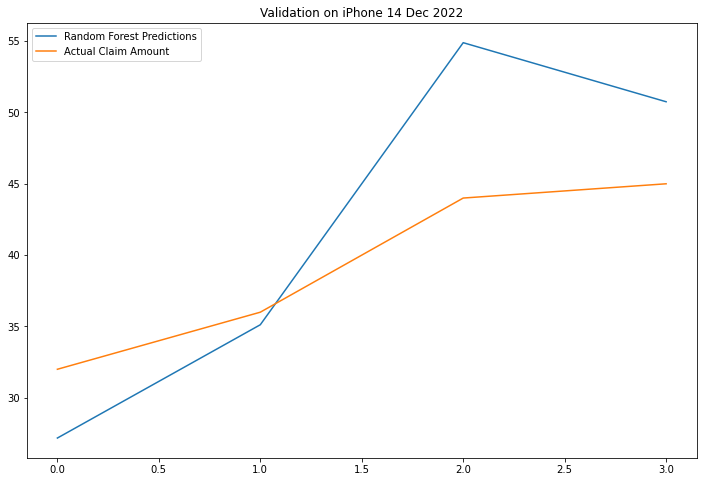

Root Mean sqaured error for Random Forest model is:  6.626865775010084
WMAPE: 14.23%


In [20]:
rf_model = RandomForestRegressor(n_estimators = 100, random_state = 42)
rf_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_validate)
plt.rcParams["figure.figsize"] = (12,8)
plt.plot(rf_pred, label = "Random Forest Predictions")
plt.plot(y_validate, label = "Actual Claim Amount")
plt.title("Validation on iPhone 14 Dec 2022")
plt.legend(loc="upper left")
plt.show()
rmse_rf = sqrt(mean_squared_error(rf_pred, y_validate))
print("Root Mean sqaured error for Random Forest model is: ", rmse_rf)

y_validate_series = pd.Series(y_validate.ravel())
rf_pred_series = pd.Series(rf_pred.ravel())
wmape_score = wmape(y_validate_series, rf_pred_series)
print("WMAPE: {:.2%}".format(wmape_score))

In [12]:
iPhone14_Dec = iphone14_df.iloc[:4].copy()
iPhone14_Dec

,days_since_release_date,weeks_monday,month,year,month_year,holiday,this_week,avg_claim_this_month,avg_claim_last_month,1_week_ago,2_week_ago,3_week_ago,4_week_ago
0,87,2022-12-12,12,2022,2022-12-01,0,32,38.75,20.666667,43.0,23.0,30.0,9.0
1,94,2022-12-19,12,2022,2022-12-01,1,36,38.75,20.666667,32.0,43.0,23.0,30.0
2,101,2022-12-26,12,2022,2022-12-01,1,44,38.75,20.666667,36.0,32.0,43.0,23.0
3,108,2023-01-02,1,2023,2023-01-01,0,45,55.00,38.750000,44.0,36.0,32.0,43.0


In [13]:
for i in range(4): 
    x1 = iPhone14_Dec.iloc[-1]['this_week']
    x2 = iPhone14_Dec.iloc[-1]['1_week_ago']
    x3 = iPhone14_Dec.iloc[-1]['2_week_ago']
    x4 = iPhone14_Dec.iloc[-1]['3_week_ago']
    x5 = iPhone14_Dec.iloc[-1]['days_since_release_date'] + 7 
    x6 = iPhone14_Dec.iloc[-1]['avg_claim_last_month']

    x1, x2, x3, x4, x5, x6 = np.array(x1), np.array(x2), np.array(x3), np.array(x4), np.array(x5), np.array(x6)
    x1, x2, x3, x4, x5, x6 = x1.reshape(-1, 1), x2.reshape(-1, 1), x3.reshape(-1, 1), x4.reshape(-1, 1), x5.reshape(-1, 1), x6.reshape(-1, 1)
    X_next = np.concatenate((x1, x2, x3, x4, x5, x6), axis = 1)
    next_pred = rf_model.predict(X_next).item()
    next_pred

    new_row = {
        'this_week': next_pred,
        '1_week_ago': x1.item(),
        '2_week_ago': x2.item(),
        '3_week_ago': x3.item(),
        '4_week_ago': x4.item(),
        'days_since_release_date': x5.item(),
        'avg_claim_last_month': x6.item()
    }

    iPhone14_Dec = iPhone14_Dec.append(new_row, ignore_index=True)
iPhone14_Dec

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,days_since_release_date,weeks_monday,month,year,month_year,holiday,this_week,avg_claim_this_month,avg_claim_last_month,1_week_ago,2_week_ago,3_week_ago,4_week_ago
0,87.0,2022-12-12,12.0,2022.0,2022-12-01,0.0,32.00,38.75,20.666667,43.00,23.00,30.00,9.0
1,94.0,2022-12-19,12.0,2022.0,2022-12-01,1.0,36.00,38.75,20.666667,32.00,43.00,23.00,30.0
2,101.0,2022-12-26,12.0,2022.0,2022-12-01,1.0,44.00,38.75,20.666667,36.00,32.00,43.00,23.0
3,108.0,2023-01-02,1.0,2023.0,2023-01-01,0.0,45.00,55.00,38.750000,44.00,36.00,32.00,43.0
4,115.0,NaT,NaN,NaN,NaT,NaN,48.43,NaN,38.750000,45.00,44.00,36.00,32.0
5,122.0,NaT,NaN,NaN,NaT,NaN,76.46,NaN,38.750000,48.43,45.00,44.00,36.0
6,129.0,NaT,NaN,NaN,NaT,NaN,106.82,NaN,38.750000,76.46,48.43,45.00,44.0
7,136.0,NaT,NaN,NaN,NaT,NaN,147.98,NaN,38.750000,106.82,76.46,48.43,45.0


In [14]:
my_pred = iPhone14_Dec['this_week'].tail(4).to_numpy()
my_pred

array([ 48.43,  76.46, 106.82, 147.98])

In [15]:
truth = np.array(iphone14_df.iloc[4:8]['this_week'].values)
truth

array([59, 60, 57, 54])

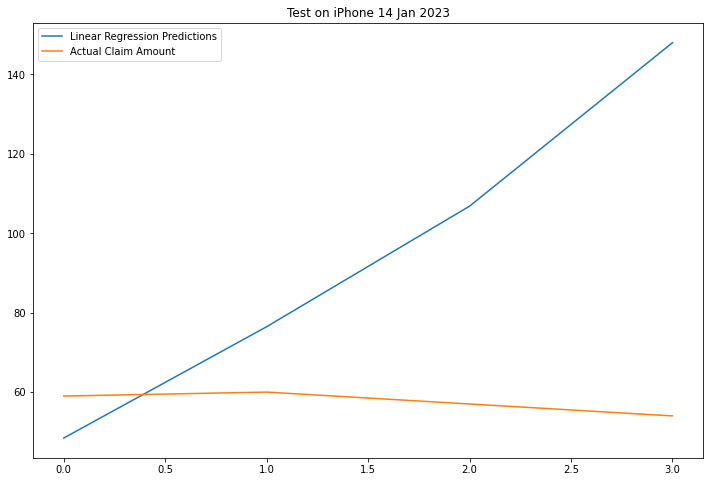

Root Mean sqaured error for Linear Regression model is:  54.07617150834552
WMAPE: 74.27%


In [16]:
plt.rcParams["figure.figsize"] = (12,8)
plt.plot(my_pred, label = "Linear Regression Predictions")
plt.plot(truth, label = "Actual Claim Amount")
plt.title("Test on iPhone 14 Jan 2023")
plt.legend(loc="upper left")
plt.show()
rmse_lr = sqrt(mean_squared_error(my_pred, truth))
print("Root Mean sqaured error for Random Forest model is: ", rmse_lr)

truth_series = pd.Series(truth.ravel())
my_pred_series = pd.Series(my_pred.ravel())
wmape_score = wmape(truth_series, my_pred_series)
print("WMAPE: {:.2%}".format(wmape_score))